# Quasilinear Theory (QLT) 
#### Bump-on-tail instability 
#### Wave-particle interaction (A.A. Galeev and R.Z. Sagdeev)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz 
import scipy
from scipy.sparse import diags

In [2]:
%matplotlib inline
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [3]:
def Z_fun(z):
    return 1j * np.sqrt(np.pi) * wofz(z)
    
def Z_p_fun(z):
    return -2*(1+z*Z_fun(z))

In [192]:
# bulk electron beam parameters
thermal_bulk = 1
density_bulk = 0.9
drift_bulk = 0

# bump electron beam 1 parameters
thermal_bump = 1
density_bump = (1-density_bulk)
drift_bump = 4.5

# wavenumber of initial perturbation
k_curr = 0.25

In [193]:
# Despersion relation
def disp_k(alpha_1=thermal_bulk, 
           alpha_2=thermal_bump,
           delta_1=density_bulk,
           delta_2=density_bump, 
           u_1=drift_bulk, 
           u_2=drift_bump, 
           k=k_curr):
    return lambda omega : 1 - delta_1*Z_p_fun((omega-k*u_1)/(np.sqrt(2)*alpha_1*k))/(2*(k**2)*(alpha_1**2))\
                            - delta_2*Z_p_fun((omega-k*u_2)/(np.sqrt(2)*alpha_2*k))/(2*(k**2)*(alpha_2**2))

In [194]:
sol = scipy.optimize.newton(disp_k(), drift_bump*k_curr+0.01j, maxiter=10000)
print("omega_k + i gamma = ", sol)
print("dispersion residual = ", abs(disp_k()(sol)))

omega_k + i gamma =  (0.8732185482309077+0.12196985079056724j)
dispersion residual =  1.2317805630257494e-12


In [195]:
print("phase velocity =", sol.real/k_curr)

phase velocity = 3.492874192923631


In [196]:
def get_D(v, E_init, omega_k, k, t, f_curr, dv):
    gamma_k = get_gamma(omega_k=omega_k, k=k, f_0=f_curr, dv=dv)
    E = get_E(gamma=gamma_k, E_init=E_init, t=t)
    return E * abs(gamma_k) / ((omega_k - k*v)**2 + gamma_k**2)

In [197]:
def get_gamma(omega_k, k, f_0, dv):
    coeff = 0.5 * np.pi * (omega_k)/(k**2)
    index = np.argmin(np.abs(v_grid - omega_k/k))
    return coeff * (f_0[int(index+1)] - f_0[int(index)]) / (dv)

In [198]:
def get_E(gamma, E_init, t):
    return E_init * np.exp(2*gamma*t)

In [199]:
def ddx_central(Nx, dx, periodic=True):
    A = diags([-1, 1], [-1, 1], shape=(Nx, Nx)).toarray()
    if periodic:
        A[0, -1] = -1
        A[-1, 0] = 1
    else:
        A[0, 0] = -3
        A[0, 1] = 4
        A[0, 2] = -1
        A[-1, -1] = 3
        A[-1, -2] = -4
        A[-1, -3] = 1
    A /= (2 * dx)
    return A

In [200]:
omega_k_init = sol.real

In [201]:
E_k_init = 1e-3

In [202]:
v_grid = np.linspace(-6, 8, int(1e3))
f_0_init = (density_bulk*np.exp(-0.5*((v_grid-drift_bulk)/thermal_bulk)**2)/thermal_bulk 
          + density_bump*np.exp(-0.5*((v_grid-drift_bump)/thermal_bump)**2)/thermal_bump)/np.sqrt(2*np.pi)

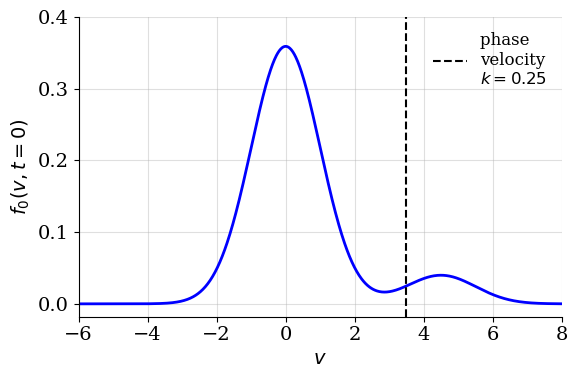

In [212]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(v_grid, f_0_init, color="blue", linewidth=2)
plt.axvline(sol.real/k_curr, color="black", ls="--", label="phase \nvelocity\n$k=0.25$")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$f_{0}(v, t=0)$")
ax.set_xlabel(r"$v$")
ax.set_xlim(np.min(v_grid), np.max(v_grid))
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
legend = ax.legend(loc='upper right', ncols=1, fancybox=False, shadow=False, fontsize=12)
legend.get_frame().set_alpha(0)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig("bump_on_tail_initial_condition.png", dpi=200, bbox_inches='tight')

In [213]:
D_derivative = ddx_central(Nx=len(v_grid), dx=np.abs(v_grid[1]-v_grid[0]), periodic=False)

In [214]:
def dydt(t, f):
    gamma_k = get_gamma(omega_k=omega_k_init, k=k_curr, f_0=f, dv=abs(v_grid[1]-v_grid[0]))
    if gamma_k <= 0:
        print("gamma = ", gamma_k)
    D_diffusion = get_D(v=v_grid, E_init=E_k_init, omega_k=omega_k_init, k=k_curr, t=t, f_curr=f, dv=np.abs(v_grid[1]-v_grid[0]))
    rhs= D_derivative @ (D_diffusion * (D_derivative @ f))
    # enforce_boundary 
    rhs[-1] = 0
    rhs[0] = 0
    return rhs

In [215]:
result = scipy.integrate.solve_ivp(fun=dydt, t_span=[0, 10], y0=f_0_init, atol=1e-16, rtol=1e-8)

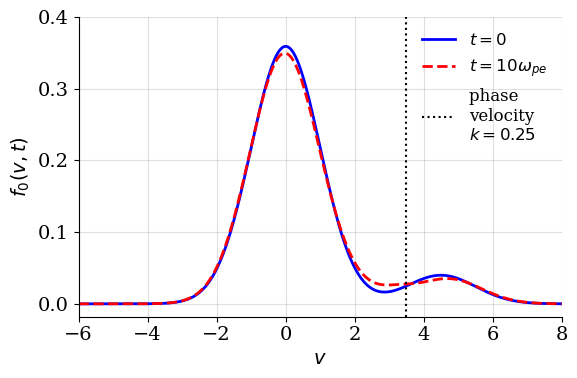

In [218]:
fig, ax = plt.subplots(figsize=(6, 4))
_ = plt.plot(v_grid, result.y[:, 0], color="blue", ls="-", linewidth=2, label=r"$t=0$")
_ = plt.plot(v_grid, result.y[:, -1], color="red", ls="--", linewidth=2, label=r"$t=10\omega_{pe}$")
plt.axvline(sol.real/k_curr, color="black", ls=":", label="phase \nvelocity\n$k=0.25$")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$f_{0}(v, t)$")
ax.set_xlabel(r"$v$")
ax.set_xlim(np.min(v_grid), np.max(v_grid))
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
legend = ax.legend(loc='upper right', ncols=1, fancybox=False, shadow=False, fontsize=12)
legend.get_frame().set_alpha(0)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig("bump_on_tail_initial_condition.png", dpi=300, bbox_inches='tight')